In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
# from sklearn.metrics import f1_score
%matplotlib inline
np.random.seed(42)

df = pd.read_pickle('../data/train_transformed.p')
order_products_compact = pd.read_hdf('../data/online_retail.h5','order_products_compact')

def f1_score(l_true,l_pred):
    tp = set(l_true).intersection(set(l_pred))
    if not len(tp):
        return 0
    fp = set(l_pred).difference(tp)
    fn = set(l_true).difference(tp)
    p = len(tp) / (len(tp) + len(fp))
    r = len(tp) / (len(tp) + len(fn))
    f1 = 2 * (p * r) / (p + r)
    return f1
def avg_f1_score(df,pred,order_products_compact=order_products_compact):
    df_pred = pd.DataFrame({'order_id':df.order_id,'pred':pred,'product_id':df.product_id}).\
                sort_values(['order_id','pred'],ascending = [True,False]).reset_index(drop=True)
    df_pred['pred_rank'] = df_pred.groupby('order_id').cumcount()
    df_pred = df_pred[df_pred.pred_rank<15].reset_index(drop=True)
    d = {}
    for row in df_pred.itertuples():
        order_id = row.order_id
        if row.pred_rank == 0 or row.pred > 0.05:
            try:
                d[order_id] += ' ' + str(row.product_id)
            except:
                d[order_id] = str(row.product_id)
    df_pred_compact = pd.DataFrame.from_dict(d, orient='index')

    df_pred_compact.reset_index(inplace=True)
    df_pred_compact.columns = ['order_id', 'y_pred']
    df_pred_compact['y_pred'] = df_pred_compact['y_pred'].str.split()
    df_pred_compact = df_pred_compact.merge(order_products_compact[['order_id','product_id']],how='left',
                                                       on='order_id')
    scores = []
    for row in df_pred_compact.itertuples():
        y_pred = row.y_pred
        y_true = row.product_id
        score = f1_score(y_true,y_pred)
        scores.append(score)
    return np.mean(scores)
def auc_score(df,pred):
    return roc_auc_score(df['labels'].values,pred)

/home/song/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df.columns

Index(['labels', 'order_id', 'product_id', 'user_id', 'user_total_orders',
       'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'user_total_item_quantity', 'user_total_spent',
       'user_sum_days_between_orders', 'user_reorder_ratio',
       'order_hour_of_day', 'order_dow', 'days_since_prior_order',
       'days_since_ratio', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'product_total_quantity_sold',
       'product_avg_price', 'prod_first_buy', 'prod_second_buy',
       'prod_1reorder_ratio', 'prod_nreorder_ratio', 'UP_orders',
       'UP_orders_ratio', 'UP_reorder_rate', 'UP_total_quantity',
       'UP_order_rate_since_first_order'],
      dtype='object')

In [3]:
f_to_use0 = ['user_total_orders',
       'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'user_total_item_quantity', 'user_total_spent',
       'user_sum_days_between_orders', 'user_reorder_ratio',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'product_orders', 'product_reorders', 'product_reorder_rate',
       'product_total_quantity_sold', 'product_avg_price', 'prod_first_buy',
       'prod_second_buy', 'prod_1reorder_ratio', 'prod_nreorder_ratio',
       'UP_orders', 'UP_orders_ratio', 'UP_reorder_rate', 'UP_total_quantity',
       'UP_order_rate_since_first_order']
f_to_use1 = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_reorder_rate']
f_to_use2 = ['user_total_orders',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_ratio',
       'product_orders', 'UP_orders']
f_to_use3 = ['user_total_orders', 'user_average_days_between_orders', 'user_average_basket', 
             'user_total_item_quantity', 'order_hour_of_day', 'days_since_ratio',
             'product_orders', 'product_avg_price', 
             'UP_orders', 'UP_total_quantity']
f_to_use4 = ['user_total_orders', 'user_average_days_between_orders', 'user_average_basket', 
             'user_total_item_quantity', 'order_hour_of_day','order_dow', 'days_since_ratio',
             'product_orders', 'product_avg_price', 
             'UP_orders', 'UP_total_quantity', 
             'user_sum_days_between_orders','user_reorder_ratio','prod_1reorder_ratio']

In [4]:
# correlation test
corr = df[f_to_use4].corr()
(corr > 0.5).sum()

user_total_orders                   2
user_average_days_between_orders    1
user_average_basket                 1
user_total_item_quantity            2
order_hour_of_day                   1
order_dow                           1
days_since_ratio                    1
product_orders                      2
product_avg_price                   1
UP_orders                           1
UP_total_quantity                   1
user_sum_days_between_orders        1
user_reorder_ratio                  1
prod_1reorder_ratio                 2
dtype: int64

In [5]:
corr

,user_total_orders,user_average_days_between_orders,user_average_basket,user_total_item_quantity,order_hour_of_day,order_dow,days_since_ratio,product_orders,product_avg_price,UP_orders,UP_total_quantity,user_sum_days_between_orders,user_reorder_ratio,prod_1reorder_ratio
user_total_orders,1.000000e+00,-4.123759e-01,7.886892e-03,5.628045e-01,-4.870814e-03,1.466262e-02,-1.020318e-01,4.435227e-17,1.907015e-19,0.200472,0.060087,2.523834e-01,3.261511e-01,1.481277e-16
user_average_days_between_orders,-4.123759e-01,1.000000e+00,2.639173e-02,-2.358832e-01,4.120785e-02,2.725396e-02,6.802189e-02,-1.249335e-17,2.671903e-18,-0.067077,-0.025184,2.690539e-01,-3.802930e-01,-7.183409e-18
user_average_basket,7.886892e-03,2.639173e-02,1.000000e+00,5.461234e-02,2.930158e-02,8.582378e-02,-2.165999e-02,-4.402257e-17,1.778213e-18,0.090046,0.005831,3.924367e-02,-3.498141e-02,-2.227520e-17
user_total_item_quantity,5.628045e-01,-2.358832e-01,5.461234e-02,1.000000e+00,-2.984752e-02,4.838119e-04,-7.512556e-02,2.020160e-18,1.311386e-18,0.115486,0.106763,1.454924e-01,2.144581e-01,1.261048e-17
order_hour_of_day,-4.870814e-03,4.120785e-02,2.930158e-02,-2.984752e-02,1.000000e+00,2.579946e-02,-2.046899e-02,-1.762072e-17,8.909364e-18,0.003410,-0.003187,3.242748e-02,-3.279095e-02,-4.344383e-17
order_dow,1.466262e-02,2.725396e-02,8.582378e-02,4.838119e-04,2.579946e-02,1.000000e+00,1.965426e-02,9.001043e-17,2.610368e-17,0.008737,0.000052,5.932038e-03,-6.681319e-04,2.195169e-17
days_since_ratio,-1.020318e-01,6.802189e-02,-2.165999e-02,-7.512556e-02,-2.046899e-02,1.965426e-02,1.000000e+00,1.310377e-17,-4.626312e-18,-0.016812,-0.008021,-1.380487e-01,-2.486770e-02,-1.310789e-16
product_orders,4.435227e-17,-1.249335e-17,-4.402257e-17,2.020160e-18,-1.762072e-17,9.001043e-17,1.310377e-17,1.000000e+00,-4.631732e-02,0.193062,0.057101,-2.330212e-17,2.462485e-17,5.298432e-01
product_avg_price,1.907015e-19,2.671903e-18,1.778213e-18,1.311386e-18,8.909364e-18,2.610368e-17,-4.626312e-18,-4.631732e-02,1.000000e+00,-0.008766,-0.006523,-2.631253e-19,-3.922376e-18,-5.017860e-02
UP_orders,2.004725e-01,-6.707733e-02,9.004567e-02,1.154858e-01,3.410053e-03,8.737468e-03,-1.681185e-02,1.930615e-01,-8.766088e-03,1.000000,0.324171,4.257595e-02,5.308537e-02,1.022769e-01


In [5]:
# train / val split
unique_users = df.user_id.unique()
np.random.shuffle(unique_users)
sp = int(len(unique_users)*0.8)
train_users = unique_users[:sp]
val_users = unique_users[sp:]
df_train = df[df.user_id.isin(train_users)]
df_val = df[df.user_id.isin(val_users)]

### basic logistical regression model

In [27]:
%%time
lgr = LogisticRegression(random_state=42,n_jobs=-1).fit(df_train[f_to_use4],df_train['labels'].values)
# train_pred = lgr.predict_proba(df_train[f_to_use2])[:,1]
val_pred_lgr = lgr.predict_proba(df_val[f_to_use4])[:,1]
# train_auc = roc_auc_score(df_train['labels'].values,train_pred)
# val_auc = roc_auc_score(df_val['labels'].values,val_pred)
# print ('train auc is {:.3f}; val auc is {:.3f}'.format(train_auc,val_auc))

CPU times: user 1min 15s, sys: 268 ms, total: 1min 15s
Wall time: 1min 15s


In [28]:
avg_f1_score(df_val,val_pred_lgr)

0.12826693825815361

In [29]:
auc_score(df_val,val_pred_lgr)

0.85174343554017151

### basic lgb model

In [79]:
%%time
d_train = lgb.Dataset(df_train[f_to_use4],label=df_train['labels'].values)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'learning_rate': 0.025
}

ROUNDS = 100
bst = lgb.train(params, d_train, ROUNDS)
# lgb.plot_importance(bst, figsize=(9,20))
val_pred_lgb = bst.predict(df_val[f_to_use4])

CPU times: user 1min 50s, sys: 452 ms, total: 1min 51s
Wall time: 14.8 s


In [80]:
avg_f1_score(df_val,val_pred_lgb)

0.18435135158668492

In [81]:
auc_score(df_val,val_pred_lgb)

0.88044725637554033

### basic ramdom forest model

In [34]:
%%time
rfc = RandomForestClassifier(random_state = 42, n_estimators=100, max_depth = 5, n_jobs=-1).\
        fit(df_train[f_to_use4],df_train['labels'].values)
val_pred_rf = rfc.predict_proba(df_val[f_to_use4])[:,1]

CPU times: user 5min 59s, sys: 1.68 s, total: 6min
Wall time: 47.3 s


In [35]:
avg_f1_score(df_val,val_pred_rf)

0.17816291035654502

In [36]:
auc_score(df_val,val_pred_rf)

0.87744299334738241

### basic xgb model

In [6]:
%%time
d_train = xgb.DMatrix(df_train[f_to_use4],label=df_train['labels'].values)

xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
ROUNDS = 100
watchlist= [(d_train, "train")]
bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=ROUNDS, evals=watchlist, verbose_eval=10)
# xgboost.plot_importance(bst)
val_pred_xgb = bst.predict(xgb.DMatrix(df_val[f_to_use4]))

[0]	train-logloss:0.600281
[10]	train-logloss:0.189777
[20]	train-logloss:0.079503
[30]	train-logloss:0.043961
[40]	train-logloss:0.032326
[50]	train-logloss:0.028563
[60]	train-logloss:0.027259
[70]	train-logloss:0.026735
[80]	train-logloss:0.026441
[90]	train-logloss:0.026217
CPU times: user 11min 58s, sys: 2.32 s, total: 12min
Wall time: 1min 33s


In [7]:
avg_f1_score(df_val,val_pred_xgb)

0.18793026220429274

In [8]:
auc_score(df_val,val_pred_xgb)

0.890591960823641

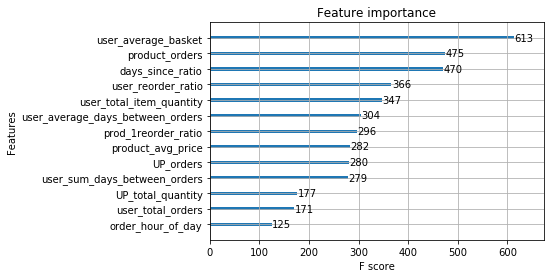

In [9]:
xgb.plot_importance(bst)

# Group K Fold CV

In [53]:
def group_kfold_cv(model = LogisticRegression(random_state=42,n_jobs=-1),f_to_use = f_to_use3):
    group_kfold = GroupKFold(n_splits=4)
    avg_f1_score_list = []
    auc_score_list = []
    i = 0
    df_shuffle = df.sample(frac=1,random_state=43).reset_index(drop=True)
    for train_index, val_index in group_kfold.split(
        X = df_shuffle[f_to_use].values, groups = df_shuffle['order_id'].values):
        i += 1
        print ('Fold {}...'.format(i))
        df_train = df_shuffle.loc[train_index]
        df_val = df_shuffle.loc[val_index]
        m = model.fit(df_train[f_to_use],df_train['labels'].values)
        val_pred = m.predict_proba(df_val[f_to_use])[:,1]
        avg_f1_score_list.append(avg_f1_score(df_val,val_pred))
        auc_score_list.append(auc_score(df_val,val_pred))
    return np.mean(avg_f1_score_list),np.mean(auc_score_list)

def group_kfold_lgb(f_to_use = f_to_use3):
    group_kfold = GroupKFold(n_splits=4)
    avg_f1_score_list = []
    auc_score_list = []
    i = 0
    df_shuffle = df.sample(frac=1,random_state=43).reset_index(drop=True)
    for train_index, val_index in group_kfold.split(
        X = df_shuffle[f_to_use].values, groups = df_shuffle['order_id'].values):
        i += 1
        print ('Fold {}...'.format(i))
        df_train = df_shuffle.loc[train_index]
        df_val = df_shuffle.loc[val_index]
        d_train = lgb.Dataset(df_train[f_to_use],label=df_train['labels'].values)
        params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'binary_logloss'},
        'num_leaves': 96,
        'max_depth': 10,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.95,
        'bagging_freq': 5
        }
        ROUNDS = 100
        bst = lgb.train(params, d_train, ROUNDS)
        val_pred = bst.predict(df_val[f_to_use])
        avg_f1_score_list.append(avg_f1_score(df_val,val_pred))
        auc_score_list.append(auc_score(df_val,val_pred))
    return np.mean(avg_f1_score_list),np.mean(auc_score_list)

def group_kfold_xgb(f_to_use = f_to_use3):
    group_kfold = GroupKFold(n_splits=4)
    avg_f1_score_list = []
    auc_score_list = []
    i = 0
    df_shuffle = df.sample(frac=1,random_state=43).reset_index(drop=True)
    for train_index, val_index in group_kfold.split(
        X = df_shuffle[f_to_use].values, groups = df_shuffle['order_id'].values):
        i += 1
        print ('Fold {}...'.format(i))
        df_train = df_shuffle.loc[train_index]
        df_val = df_shuffle.loc[val_index]
        d_train = xgb.DMatrix(df_train[f_to_use],label=df_train['labels'].values)

        xgb_params = {
            "objective"         : "reg:logistic"
            ,"eval_metric"      : "logloss"
            ,"eta"              : 0.1
            ,"max_depth"        : 6
            ,"min_child_weight" :10
            ,"gamma"            :0.70
            ,"subsample"        :0.76
            ,"colsample_bytree" :0.95
            ,"alpha"            :2e-05
            ,"lambda"           :10
        }
        ROUNDS = 100
#         watchlist= [(d_train, "train")]
        bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=ROUNDS)
        val_pred = bst.predict(xgb.DMatrix(df_val[f_to_use]))
        avg_f1_score_list.append(avg_f1_score(df_val,val_pred))
        auc_score_list.append(auc_score(df_val,val_pred))
    return np.mean(avg_f1_score_list),np.mean(auc_score_list)

In [60]:
%%time
group_kfold_cv()

Fold 1...
Fold 2...
Fold 3...
Fold 4...
CPU times: user 1min 10s, sys: 2.32 s, total: 1min 12s
Wall time: 1min 10s


(0.13208674109339155, 0.83524917996384851)

In [61]:
%%time
group_kfold_cv(RandomForestClassifier(random_state = 42, n_estimators=100, max_depth = 5, n_jobs=-1))

Fold 1...
Fold 2...
Fold 3...
Fold 4...
CPU times: user 26min 12s, sys: 10.2 s, total: 26min 22s
Wall time: 3min 32s


(0.17959987400227559, 0.8660472661686186)

In [64]:
%%time
group_kfold_lgb()

Fold 1...
Fold 2...
Fold 3...
Fold 4...
CPU times: user 7min 59s, sys: 1.3 s, total: 8min
Wall time: 1min 4s


(0.17928740680159366, 0.87701008867151198)

In [23]:
%%time
group_kfold_xgb()

Fold 1...
Fold 2...
Fold 3...
Fold 4...
CPU times: user 1h 4min 1s, sys: 10.4 s, total: 1h 4min 12s
Wall time: 8min 24s


(0.18824797592072021, 0.8803443391638035)